In [1]:
from google.colab import files
uploaded = files.upload()

Saving Eiffel Tower.jpg to Eiffel Tower (1).jpg
Saving Oil Painting.jpg to Oil Painting.jpg


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Step 10, Loss: 420247920181248.00
Step 20, Loss: 323062004187136.00
Step 30, Loss: 266735370371072.00
Step 40, Loss: 221922151366656.00
Step 50, Loss: 186059711315968.00


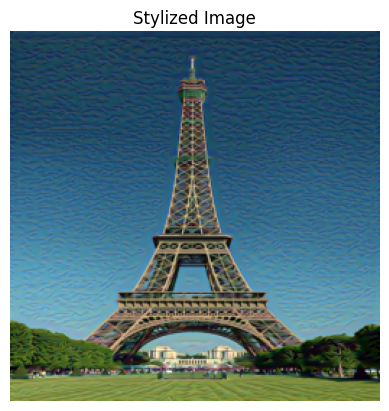

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt

device = torch.device("cpu")  # Use CPU to avoid GPU crashes

def load_image(path, max_size=256):
    image = Image.open(path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((max_size, max_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
    return transform(image).unsqueeze(0).to(device)

def im_convert(tensor):
    image = tensor.clone().detach().cpu().squeeze(0)
    image = image * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1) + \
            torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    return transforms.ToPILImage()(image.clamp(0,1))

content = load_image("Eiffel Tower.jpg", max_size=256)
style = load_image("Oil Painting.jpg", max_size=256)

vgg = models.vgg19(pretrained=True).features.to(device).eval()
for p in vgg.parameters():
    p.requires_grad = False

layer_map = {'0': 'conv1_1', '5': 'conv2_1'}
content_layer = 'conv2_1'
style_layers = ['conv1_1', 'conv2_1']

def get_features(x):
    features = {}
    for name, layer in vgg._modules.items():
        x = layer(x)
        if name in layer_map:
            features[layer_map[name]] = x
    return features

def gram_matrix(tensor):
    b, c, h, w = tensor.size()
    tensor = tensor.view(c, h * w)
    return torch.mm(tensor, tensor.t())

content_feat = get_features(content)
style_feat = get_features(style)
style_grams = {l: gram_matrix(style_feat[l]) for l in style_layers}

target = content.clone().requires_grad_(True)
optimizer = optim.Adam([target], lr=0.005)
style_weight, content_weight = 1e6, 1

for i in range(50):  # fewer epochs
    target_feat = get_features(target)
    content_loss = torch.mean((target_feat[content_layer] - content_feat[content_layer])**2)
    style_loss = 0
    for l in style_layers:
        target_gram = gram_matrix(target_feat[l])
        style_gram = style_grams[l]
        style_loss += torch.mean((target_gram - style_gram)**2)
    total_loss = style_weight * style_loss + content_weight * content_loss
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    if (i+1) % 10 == 0:
        print(f"Step {i+1}, Loss: {total_loss.item():.2f}")

plt.imshow(im_convert(target))
plt.axis("off")
plt.title("Stylized Image")
plt.show()

In [ ]:
# Convert content, style, and target tensors to PIL images
content_image = im_convert(content)
style_image = im_convert(style)
output_image = im_convert(target)

# Plot all three images side by side
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))

# Content Image
ax1.imshow(content_image)
ax1.set_title("Content Image")
ax1.axis("off")

# Style Image
ax2.imshow(style_image)
ax2.set_title("Style Image")
ax2.axis("off")

# Stylized Output Image
ax3.imshow(output_image)
ax3.set_title("Stylized Image")
ax3.axis("off")

plt.show()